In [1]:
import pandas as pd

In [3]:
posts_file = "data/rspct_autos.tsv"
posts_df = pd.read_csv(posts_file, sep="\t")

subred_file = "data/subreddit_info.csv.gz"
subred_df = pd.read_csv(subred_file).set_index(["subreddit"])

df = posts_df.join(subred_df, on="subreddit")

### Blueprint: Standardizing Attribute Names

In [9]:
df.columns

Index(['id', 'subreddit', 'title', 'selftext', 'category_1', 'category_2',
       'category_3', 'in_data', 'reason_for_exclusion'],
      dtype='object')

In [10]:
column_mapping = {
    "id": "id",
    "subreddit": "subreddit",
    "title": "title",
    "selftext": "text",
    "category_1": "category",
    "category_2": "subcategory",
    "category_3": None,  # No data.
    "in_data": None,  # Not needed.
    "reason_for_exclusion": None,  # Not needed.
}

# Define remaining columns.
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]

# Select and rename those columns.
df = df[columns].rename(columns=column_mapping)

# Limit the data to autos category.
df = df[df["category"] == "autos"]
df.sample(1).T

,8020
id,63wxeo
subreddit,mazda3
title,Blew my motor :(
text,my 08 hatch spun a rod bearing the other day a...
category,autos
subcategory,mazda


**Saving and loading a Dataframe**

Storing in SQL has more advantages over pickle.

In [12]:
# df.to_pickle('reddit_dataframe.pkl')

import sqlite3

db_name = "reddit-selfposts.db"
con = sqlite3.connect(db_name)
df.to_sql("posts", con, index=False, if_exists="replace")
con.close()

In [13]:
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts", con)
con.close()

## Cleaning Text Data

### Blueprint: Identify Noise with Regular Expressions

In [20]:
import re

RE_SUSPICIOUS = re.compile(r"[&#<>{}\[\]\\]")


def impurity(text, min_len=10):
    """Returns the share of suspicious characters in a text."""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text)) / len(text)


text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)     
it got me thinking about the best match ups.     
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)     
Captain America<lb>"""

impurity(text)

0.08438818565400844

In [21]:
# Add new column to data frame.
df["impurity"] = df["text"].apply(impurity, min_len=10)

# Get the top 3 records.
df[["text", "impurity"]].sort_values(by="impurity", ascending=False)

,text,impurity
19682,Looking at buying a 335i with 39k miles and 11...,0.214716
12357,I'm looking to lease an a4 premium plus automa...,0.165099
2730,Breakdown below:<lb><lb>Elantra GT<lb><lb>2.0L...,0.139130
12754,Bulbs Needed:<lb><lb><lb>**194 LED BULB x8**<l...,0.132411
10726,I currently have a deposit on a 2013 335is (CP...,0.129317
...,...,...
15867,All the wash places around me are very expensi...,0.000000
8311,I've recently been having some issues with my ...,0.000000
15865,My 2006 9-3 has gone into limp home mode and I...,0.000000
15864,I'm currently looking at cars (online) and I c...,0.000000


In [22]:
%run exploration.py

In [25]:
count_words(df, column="text", preprocess=lambda t: re.findall(r"<[\w/]*>", t))

,freq
token,
<lb>,100729
<tab>,642


### Blueprint: Removing Noise with Regular Expressions

In [26]:
import html


def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)

    # tags like <tab>
    text = re.sub(r"<[^<>]*>", " ", text)

    # markdown URLs like [Some text](https://....)
    text = re.sub(r"\[([^\[\]]*)\]\([^\(\)]*\)", r"\1", text)

    # text or code in brackets like [0]
    text = re.sub(r"\[[^\[\]]*\]", " ", text)

    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r"(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)", " ", text)

    # standalone sequences of hyphens like --- or ==
    text = re.sub(r"(?:^|\s)[\-=\+]{2,}(?:\s|$)", " ", text)

    # sequences of white spaces
    text = re.sub(r"\s+", " ", text)

    return text.strip()

In [27]:
clean_text = clean(text)
clean_text

"After viewing the PINKIEPOOL Trailer it got me thinking about the best match ups. Here's my take: Deadpool Captain America"

In [29]:
print("Impurity:", impurity(clean_text))

Impurity: 0.0


In [31]:
df["clean_text"] = df["text"].map(clean)
df["impurity"] = df["clean_text"].apply(impurity, min_len=20)
df[["clean_text", "impurity"]].sort_values(by="impurity", ascending=False).head(3)

,clean_text,impurity
14058,"Mustang 2018, 2019, or 2020? Must Haves!! 1. H...",0.030864
18934,"At the dealership, they offered an option for ...",0.026455
16505,"I am looking at four Caymans, all are in a sim...",0.024631


### Blueprint: Character Normalization with textacy

In [32]:
import textacy.preprocessing as tprep

In [37]:
def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

In [38]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."
normalize(text)

'The cafe "Saint-Raphael" is located on Cote d\'Azur.'

### Blueprint: Pattern-Based Data Masking with textacy

In [41]:
from textacy.preprocessing.resources import RE_URL

In [43]:
count_words(df, column="clean_text", preprocess=RE_URL.findall).head(3)

,freq
token,
www.getlowered.com,3
http://www.ecolamautomotive.com/#!2/kv7fq,2
https://www.reddit.com/r/Jeep/comments/4ux232/just_ordered_an_android_head_unit_joying_jeep/,2


In [49]:
from textacy.preprocessing.replace import urls as replace_urls

text = "Check out https://spacy.io/usage/spacy-101"
print(replace_urls(text))

Check out _URL_


In [50]:
df["clean_text"] = df["clean_text"].map(replace_urls)
df["clean_text"] = df["clean_text"].map(normalize)

In [51]:
df.rename(columns={"text": "raw_text", "clean_text": "text"}, inplace=True)
df.drop(columns=["impurity"], inplace=True)

con = sqlite3.connect(db_name)
df.to_sql("posts_cleaned", con, index=False, if_exists="replace")
con.close()

## Tokenization

In [52]:
text = """2019-08-10 23:32: @pete/@louis - I don't have a well-designed solution for today's problem. The code of module AC68 should be -1. Have to think a bit... #goodnight ;-) 😩😬"""

### Blueprint: Tokenization with Regular Expression

In [54]:
tokens = re.findall(r"\w\w+", text)
print(*tokens, sep="|")

2019|08|10|23|32|pete|louis|don|have|well|designed|solution|for|today|problem|The|code|of|module|AC68|should|be|Have|to|think|bit|goodnight


In [55]:
RE_TOKEN = re.compile(
    r"""
               ( [#]?[@\w'’\.\-\:]*\w     # words, hash tags and email adresses
               | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
               | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
               )
               """,
    re.VERBOSE,
)


def tokenize(text):
    return RE_TOKEN.findall(text)


tokens = tokenize(text)
print(*tokens, sep="|")

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


### Tokenization with NLTK

In [57]:
import nltk

tokens = nltk.tokenize.word_tokenize(text)
print(*tokens, sep="|")

2019-08-10|23:32|:|@|pete/|@|louis|-|I|do|n't|have|a|well-designed|solution|for|today|'s|problem|.|The|code|of|module|AC68|should|be|-1|.|Have|to|think|a|bit|...|#|goodnight|;|-|)|😩😬


### Linguistic Processing with spaCy

**Instantiating a Pipeline**

In [59]:
import spacy

nlp = spacy.load("en_core_web_sm")
nlp.pipeline

In [64]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x131a6bdb0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1338876d0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1317f4c40>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x13169f580>)]

**Processing Text**



In [67]:
nlp = spacy.load("en_core_web_sm")
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [68]:
for token in doc:
    print(token, end="|")

My|best|friend|Ryan|Peters|likes|fancy|adventure|games|.|

In [70]:
# To see a list of attributes created by spaCy on the token.
# help(token)

In [80]:
def display_nlp(doc, include_punct=False):
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {
                "token": i,
                "text": t.text,
                "lemma_": t.lemma_,
                "is_stop": t.is_stop,
                "is_alpha": t.is_alpha,
                "pos_": t.pos_,
                "dep_": t.dep_,
                "ent_type_": t.ent_type_,
                "ent_iob_": t.ent_iob_,
            }
            rows.append(row)

    df = pd.DataFrame(rows).set_index("token")
    df.index.name = None
    return df

In [81]:
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,My,my,True,True,PRON,poss,,O
1,best,good,False,True,ADJ,amod,,O
2,friend,friend,False,True,NOUN,nsubj,,O
3,Ryan,Ryan,False,True,PROPN,compound,PERSON,B
4,Peters,Peters,False,True,PROPN,appos,PERSON,I
5,likes,like,False,True,VERB,ROOT,,O
6,fancy,fancy,False,True,ADJ,amod,,O
7,adventure,adventure,False,True,NOUN,compound,,O
8,games,game,False,True,NOUN,dobj,,O


### Blueprint: Customizing Tokenization

In [83]:
text = "@Pete: choose low-carb #food #eat-smart. _url_ ;-)"
doc = nlp(text)
for token in doc:
    print(token, end="|")

@Pete|:|choose|low|-|carb|#|food|#|eat|-|smart|.|_|url|_|;-)|

In [87]:
from spacy.tokenizer import Tokenizer
from spacy.util import compile_infix_regex, compile_prefix_regex, compile_suffix_regex


def custom_tokenizer(nlp):
    # Use default patterns except the ones matched by re.search.
    prefixes = [
        pattern for pattern in nlp.Defaults.prefixes if pattern not in ["-", "_", "#"]
    ]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes if pattern not in ["_"]]
    infixes = [
        pattern for pattern in nlp.Defaults.infixes if not re.search(pattern, "xx-xx")
    ]

    return Tokenizer(
        vocab=nlp.vocab,
        rules=nlp.Defaults.tokenizer_exceptions,
        prefix_search=compile_prefix_regex(prefixes).search,
        suffix_search=compile_suffix_regex(suffixes).search,
        infix_finditer=compile_infix_regex(infixes).finditer,
        token_match=nlp.Defaults.token_match,
    )

In [89]:
nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = custom_tokenizer(nlp)

doc = nlp(text)
for token in doc:
    print(token, end="|")

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|

### Blueprint: Working with Stop Words

In [90]:
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)

non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, talk, Regards, Pete]


In [94]:
nlp = spacy.load("en_core_web_sm")
nlp.vocab["down"].is_stop = False
nlp.vocab["Dear"].is_stop = True
nlp.vocab["Regards"].is_stop = True

doc = nlp(text)

non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Ryan, need, sit, down, talk, Pete]


### Blueprint: Extracting Lemmas Based on Part of Speech

In [101]:
text = "My best friend Ryan Peters likes fancy adventure games."

nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

print(*[t.lemma_ for t in doc], sep="|")

my|good|friend|Ryan|Peters|like|fancy|adventure|game|.


In [102]:
nouns = [t for t in doc if t.pos_ in ["NOUN", "PROPN"]]
nouns

[friend, Ryan, Peters, adventure, games]

In [106]:
import textacy

tokens = textacy.extract.words(
    doc,
    filter_stops=True,  # Default True, no stopwords.
    filter_punct=True,  # Default True, no punctuation.
    filter_nums=True,  # Default False, no numbers.
    include_pos=["ADJ", "NOUN"],  # Default None = include all
    exclude_pos=None,  # Default None = exclude none,
    min_freq=1,  # Minimum frequency of words.
)
print(*[t for t in tokens], sep="|")

best|friend|fancy|adventure|games


In [107]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]


lemmas = extract_lemmas(doc, include_pos=["ADJ", "NOUN"])
print(*lemmas, sep="|")

good|friend|fancy|adventure|game


### Blueprint: Extracting Noun Phrases

The pattern below extracts sequences of nouns with a preceding adjectives.

In [109]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

patterns = ["POS:ADJ POS:NOUN:+"]
spans = textacy.extract.token_matches(doc, patterns=patterns)
print(*[s.lemma_ for s in spans], sep="|")

good friend|fancy adventure|fancy adventure game


In [110]:
print(*doc.noun_chunks, sep="|")

My best friend|Ryan Peters|fancy adventure games


In [111]:
def extract_noun_phrases(doc, preceding_pos=["NOUN"], sep="_"):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")
    spans = textacy.extract.token_matches(doc, patterns=patterns)
    return [sep.join([t.lemma_ for t in s]) for s in spans]

In [113]:
print(*extract_noun_phrases(doc, ["ADJ", "NOUN"]), sep="|")

good_friend|fancy_adventure|fancy_adventure_game|adventure_game


### Blueprint: Extracting Named Entities

In [114]:
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."

doc = nlp(text)
for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")

(James O'Neill, PERSON) (World Cargo Inc, ORG) (San Francisco, GPE) 

In [115]:
from spacy import displacy

displacy.render(doc, style="ent")

In [116]:
def extract_entities(doc, include_types=None, sep="_"):
    ents = textacy.extract.entities(
        doc,
        include_types=include_types,
        exclude_types=None,
        drop_determiners=True,
        min_freq=1,
    )

    return [sep.join([t.lemma_ for t in e]) + "/" + e.label_ for e in ents]


extract_entities(doc, ["PERSON", "GPE"])

["James_O'Neill/PERSON", 'San_Francisco/GPE']

## Feature Extraction on Large Dataset

In [129]:
def extract_nlp(doc):
    return {
        "lemmas": extract_lemmas(
            doc,
            exclude_pos=["PART", "PUNCT", "DET", "PRON", "SYM", "SPACE"],
            filter_stops=False,
        ),
        "adjs_verbs": extract_lemmas(doc, include_pos=["ADJ", "VERB"]),
        "nouns": extract_lemmas(doc, include_pos=["NOUN", "PROPN"]),
        "noun_phrases": extract_noun_phrases(doc, ["NOUN"]),
        "adj_noun_phrases": extract_noun_phrases(doc, ["ADJ"]),
        "entities": extract_entities(doc, ["PERSON", "ORG", "GPE", "LOC"]),
    }

In [130]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']
adjs_verbs: ['good', 'like', 'fancy']
nouns: ['friend', 'Ryan', 'Peters', 'adventure', 'game']
noun_phrases: ['adventure_game']
adj_noun_phrases: ['good_friend', 'fancy_adventure', 'fancy_adventure_game']
entities: ['Ryan_Peters/PERSON']


In [131]:
nlp_columns = list(extract_nlp(nlp.make_doc("")).keys())
nlp_columns

['lemmas',
 'adjs_verbs',
 'nouns',
 'noun_phrases',
 'adj_noun_phrases',
 'entities']

### Blueprint: Using spaCy on a Large Dataset

In [132]:
db_name = "data/reddit-selfposts.db"
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts_cleaned", con)
con.close()

df["text"] = df["title"] + ": " + df["text"]

In [133]:
# Initialize new DataFrame columns.
for col in nlp_columns:
    df[col] = None

In [ ]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

In [ ]:
df = df.sample(500)

In [140]:
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm", disable=[])
nlp.tokenizer = custom_tokenizer(nlp)

batch_size = 50

for i in tqdm(range(0, len(df), batch_size)):
    docs = nlp.pipe(df["text"][i : i + batch_size])
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i + j] = values

100%|██████████| 400/400 [06:58<00:00,  1.05s/it]


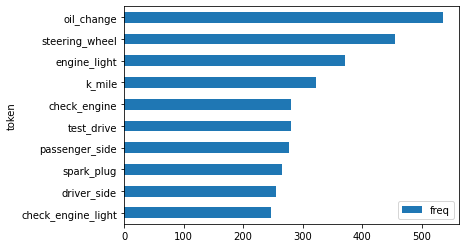

In [141]:
count_words(df, "noun_phrases").head(10).plot(kind="barh").invert_yaxis()

In [142]:
df[nlp_columns] = df[nlp_columns].applymap(lambda items: " ".join(items))

con = sqlite3.connect(db_name)
df.to_sql("posts_nlp", con, index=False, if_exists="replace")
con.close()